## Initialization and Package Import

In [297]:
import pandas as pd
import networkx as nx
import numpy as np

import random
%matplotlib inline
#%config InlineBackend.figure_formats = ['retina']

'''algo collected from https://github.com/hhchen1105/networkx_addon.git'''
from networkx_addon.information_propagation import linear_threshold, independent_cascade

import seaborn as sns

import matplotlib.pyplot as plt
import math
import json
import datetime

from collections import defaultdict

import dask
import dask.dataframe as ddf
from dask import threaded, multiprocessing
number_of_process = 4

from scipy.stats import poisson

sns.set()
sns.set_context('paper')

'algo collected from https://github.com/hhchen1105/networkx_addon.git'

## Read Datasets

In [19]:
network_file = "datasets/twitter_2013/follower_gcc.anony.dat" #the network of twitter reciprocal follower network
hashtag_file = "datasets/twitter_2013/timeline_tag.anony.dat" #tags with timestamps

In [20]:
edge_list = pd.read_csv(network_file, sep=' ', names=['src', 'dst'])

In [21]:
len(edge_list)

14273311

In [7]:
%%time
network = nx.from_pandas_edgelist(edge_list, source = 'src', target='dst')

CPU times: user 30.5 s, sys: 1.79 s, total: 32.3 s
Wall time: 32.3 s


In [8]:
nx.info(network)

'Name: \nType: Graph\nNumber of nodes: 475311\nNumber of edges: 2735341\nAverage degree:  11.5097'

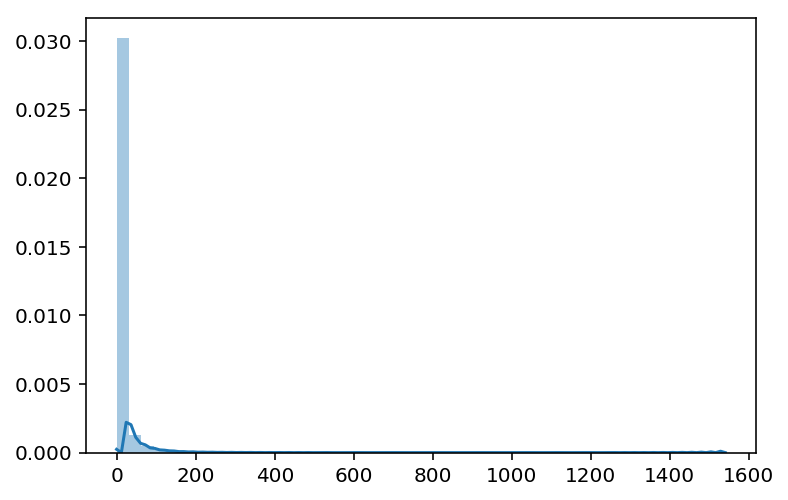

In [19]:
import collections

degree_sequence = sorted([d for n, d in network.degree()], reverse=True)  # degree sequence

sns.distplot(degree_sequence)

### Parse data

In [9]:
tags_considered = ['carryon', 'cartoon', 'dontwifethatchick', 'dontworry', 'dontyouhate', 'happybirthdayjmac',
                  'happygirl', 'happyhour', 'iknowitsreal', 'jeremykyle', 'maddog', 'maddow', 'naomie','nap',
                  'promocaocdbrasil', 'promote', 'session', 'setitoff', 'sex', 'teamcamilla']

tag_file = open(hashtag_file, 'r')

dic = {}
for i in tag_file.readlines():
    key, space, val = i.partition(" ")
    
    if key in tags_considered:
        dic[key] = val

tag_file.close()

In [10]:
data = []
for key, val in dic.items():
    allData = val.split(" ")
    for tweet in allData:
        timestamp, sep, user = tweet.partition(",")
        data.append([int(timestamp), int(user), key])

In [11]:
event_df = pd.DataFrame(data, columns=['ts', 'user_id', 'hashtag'])
del dic
del data

In [12]:
set_background('rgba(255, 0, 0, 0.1)')

def idenfity_src_net(row, net, event_df):
    node = row['user_id']
    hashtag = row['hashtag']
    
    '''finding the src of the #tag.
        considering the senario that more than one 
        parents have the hash tag, the latest one will be cosidered
        as the influencer.
    '''
    event_time = row['ts']
    parents_time = -1
    src = -1
    
    if node not in net:
        return pd.Series({'src':src})
    
    parents = pd.DataFrame(list(net.neighbors(node)), columns=['neighbor'])
    
    events_for_tag = event_df[event_df.hashtag == hashtag]
    
    parent_events = events_for_tag.merge(parents, left_on='user_id', right_on='neighbor', 
                                   how='inner')
    
    '''window size is not specified'''
    parent_events_with_tag = parent_events[(parent_events.ts < event_time)]
    
    '''Option for optimization: filter first then merge against merge and filter'''
    #'''
    
    '''the window size is set to 10 ' ' ' 
    parent_events_with_tag = parent_events[(parent_events.hashtag == hashtag) 
                                           & (parent_events.ts < event_time) 
                                           & (event_time - parent_events.ts < 10)]
    '''
    
    parent_events_with_max_ts = parent_events_with_tag[parent_events_with_tag.ts >= 
                                                       parent_events_with_tag.ts.max()]
    
    if(len(parent_events_with_max_ts) > 0):
        src = parent_events_with_max_ts.iloc[0].user_id
        
    return pd.Series({'src':src})

## Preprocessing: add src of each event

In [13]:
%%time
new = event_df.apply(idenfity_src, args=(edge_list, event_df), axis=1)
events_with_flow_src = pd.concat([event_df, new], axis=1)

del new

CPU times: user 2min 40s, sys: 318 ms, total: 2min 40s
Wall time: 2min 41s


In [28]:
events_with_flow_src[(events_with_flow_src.hashtag == 'cartoon')].head()# & (events_with_flow_src.src == -1)]

ts  user_id  hashtag  src
372  1332579664   201335  cartoon   -1
373  1332630171   595991  cartoon   -1
374  1332634050   121934  cartoon   -1
375  1332657494   201335  cartoon   -1
376  1332668788   474705  cartoon   -1

## tag delay

## Identifying external nodes to the network

### Finding the clasters

In [ ]:
#set_background('rgba(0, 255, 0, 0.1)')

tag_file = open(hashtag_file, 'r')

dic = {}
for i in tag_file.readlines():
    key, space, val = i.partition(" ")
    
    dic[key] = val

tag_file.close()

data = []
for key, val in dic.items():
    allData = val.split(" ")
    for tweet in allData:
        timestamp, sep, user = tweet.partition(",")
        data.append([int(timestamp), int(user), key])

del dic
        
all_event_df = pd.DataFrame(data, columns=['ts', 'user_id', 'hashtag'])

In [ ]:
#all_event_df.to_csv('datasets/twitter_2013/uid-hash-time.csv')

In [3]:
import pickle

def save_obj(obj, name):
    with open('datasets/obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('datasets/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
all_event_df.head()

ts  user_id         hashtag
0  1334561209    66414  00000000000gcf
1  1334922087   546702          00008b
2  1334922594    16092          00008b
3  1334928505    16092          0000cc
4  1334928793   556083          0000cc

In [ ]:
%%time

neighbors = {}
for index, row in edge_list.iterrows():
    src = row['src']
    dst = row['dst'] 
    
    neighbors.setdefault(src, set()).add(dst)
    neighbors.setdefault(dst, set()).add(src)
    
    if(index%1000000 == 0):
        print("done ", len(neighbors))

In [11]:
len(neighbors)

595460

In [33]:
",".join(map(str,neighbors[0]))

'1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66'

In [35]:
%%time

with open("datasets/twitter_2013/neighbors.lst", "w") as outfile:
    outfile.write("{")
    for key, val in neighbors.items():
        outfile.write('"{0}":["{1}"],'.format(key, '","'.join(map(str,val))))
    outfile.write("}")

CPU times: user 38.2 s, sys: 12.6 s, total: 50.8 s
Wall time: 2min 43s


In [26]:
sys.int_info

sys.int_info(bits_per_digit=30, sizeof_digit=4)

In [ ]:
%%time 
all_event_df = pd.read_csv('datasets/twitter_2013/uid-hash-time.csv', index_col=0)

In [83]:
len(all_event_df)

12054205

In [7]:
freq = all_event_df.groupby(by='user_id').count()

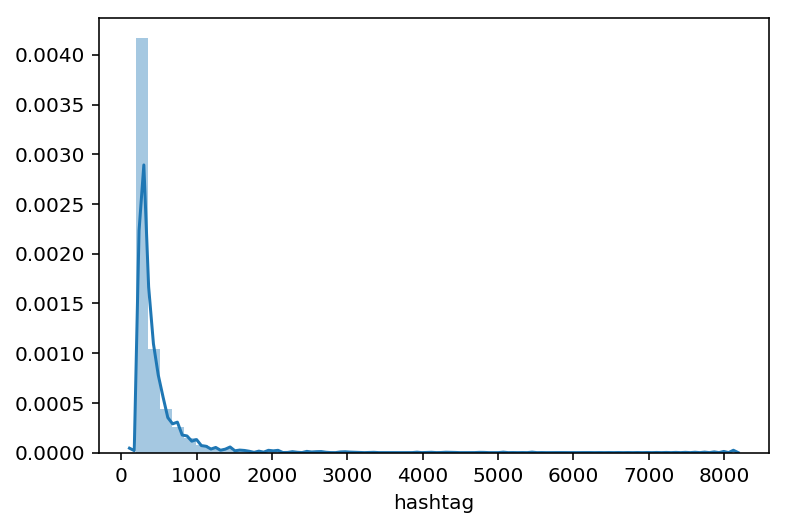

In [14]:
sns.distplot(freq.hashtag[freq.hashtag>200])

In [5]:
%%time 
neighbors = {}

with open("datasets/twitter_2013/neighbors.lst") as outfile:
    neighbors = json.load(outfile)

CPU times: user 4.92 s, sys: 1.2 s, total: 6.12 s
Wall time: 8.37 s


In [6]:
len(neighbors)

595460

In [8]:
neighbors['595459']

['367712']

In [85]:
%%time 

sorted = all_event_df.sort_values(by='ts')

CPU times: user 5.3 s, sys: 464 ms, total: 5.77 s
Wall time: 5.76 s


In [12]:
sorted.head()

ts  user_id              hashtag
4792597  1332565200    95315                   js
6900998  1332565200   134826                ongod
264287   1332565200   112546  3daysuntilboyfriend
9055159  1332565200   279120             stopthat
7714792  1332565200    95315                proud

In [14]:
len(sorted)

12054205

In [15]:
sorted.max()

ts         1335416399
user_id        612324
dtype: int64

In [89]:
sorted.ts.min()
sorted.ts.max()

1332565200

1335416399

In [19]:
datetime.datetime.fromtimestamp(1332565200)

datetime.datetime(2012, 3, 24, 6, 0)

In [36]:
datetime.datetime.fromtimestamp(1334658334)

datetime.datetime(2012, 4, 17, 12, 25, 34)

In [86]:
%%time 

quantile = sorted.ts.quantile([0.0, 0.25,0.5,0.75, 1.0])

CPU times: user 281 ms, sys: 48 ms, total: 329 ms
Wall time: 326 ms


In [87]:
%%time 

training = sorted[sorted.ts <= quantile[0.75]]
testing = sorted[sorted.ts > quantile[0.75]]

CPU times: user 700 ms, sys: 164 ms, total: 864 ms
Wall time: 859 ms


In [10]:
testing.groupby(by="user_id").hashtag.count()[3]

4

In [27]:
from collections import defaultdict

posted_known_tags = defaultdict(int)

posted_known_tags[1] += 7
posted_known_tags[1]

7

### preparing day wise stat for training set

In [ ]:
%%time

min = 1332565200
max = min + 86400

slotid = 1

data = []

while min < quantile[0.75]:    
    events = training[(training.ts >= min) & (training.ts < max)]
    
    #posted_tags = {}
    p_kn_tag_count = defaultdict(int)
    known_tag = {}
    inbound_p_count = defaultdict(int)
    
    for index, row in events.iterrows():
        #posted_tags.setdefault(row.user_id, list()).append(row.hashtag)
        
        if(row.hashtag in known_tag.setdefault(row.user_id, set())):
            p_kn_tag_count[row.user_id] += 1
        
        '''We may need to keep track that a user may know its own posts, so 
        after he new, even if some neighbor post the same tag it should not be 
        considered as known tags!'''
        #known_tag.setdefault(row.user_id, set()).add(row.hashtag)
        try:
            nbrs = neighbors[str(row.user_id)]
            for n in nbrs:
                node = int(n)
                known_tag.setdefault(node, set()).add(row.hashtag)
                inbound_p_count[node] += 1
        except KeyError:
            continue
    
    posted_tag_counts = events.groupby(by="user_id").hashtag.count()
    for node in events.user_id.unique():
        p_tag_count = posted_tag_counts[node]
        p_k_tag_count = p_kn_tag_count[node]
        in_pulses_count = inbound_p_count[node]
        
        data.append([slotid, node, p_tag_count, p_k_tag_count, in_pulses_count])
        
    #break
    
    #data.append([slotid, ])
    print("done day {}".format(slotid))
    
    min = max
    max = min + 86400
    
    slotid += 1
    
    if max > quantile[0.75]:
        max = quantile[0.75]


done day 1
done day 2
done day 3
done day 4
done day 5
done day 6


In [12]:
daily_stat = pd.DataFrame(data, columns=['slot_id', 'user_id', 'post_count', 'post_kn_count', 'total_pulses'])

In [13]:
%%time 
#daily_stat.to_csv("datasets/twitter_2013/training-daily-stat.csv")
daily_stat = pd.read_csv("datasets/twitter_2013/training-daily-stat.csv", index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 4.42 s, sys: 392 ms, total: 4.81 s
Wall time: 4.82 s


In [14]:
daily_stat.head()

slot_id  user_id  post_count  post_kn_count  total_pulses
0        1    95315          25              9           444
1        1   134826           2              0            85
2        1   112546           2              0           261
3        1   279120           1              0            14
4        1    74017           1              0             3

In [17]:
x = np.array(daily_stat.groupby(by='slot_id').sum().post_count)

In [31]:
x[:24]/1000

array([ 306.706,  336.079,  256.71 ,  364.149,  366.837,  361.612,
        383.796,  370.92 ,  356.648,  294.501,  447.867,  415.344,
        391.615,  433.639,  379.137,  382.559,  411.144,  390.317,
        404.996,  391.596,  407.596,  331.529,  357.674,  368.901])

### preparing daywise stat for testing sample

In [91]:
%%time

min = quantile[0.75]
max = min + 86400

slotid = 1

data = []

while min < 1335416399:    
    events = testing[(testing.ts >= min) & (testing.ts < max)]
    
    #posted_tags = {}
    p_kn_tag_count = defaultdict(int)
    known_tag = {}
    inbound_p_count = defaultdict(int)
    
    for index, row in events.iterrows():
        #posted_tags.setdefault(row.user_id, list()).append(row.hashtag)
        
        if(row.hashtag in known_tag.setdefault(row.user_id, set())):
            p_kn_tag_count[row.user_id] += 1
        
        '''We may need to keep track that a user may know its own posts, so 
        after he new, even if some neighbor post the same tag it should not be 
        considered as known tags!'''
        #known_tag.setdefault(row.user_id, set()).add(row.hashtag)
        try:
            nbrs = neighbors[str(row.user_id)]
            for n in nbrs:
                node = int(n)
                known_tag.setdefault(node, set()).add(row.hashtag)
                inbound_p_count[node] += 1
        except KeyError:
            continue
    
    posted_tag_counts = events.groupby(by="user_id").hashtag.count()
    for node in events.user_id.unique():
        p_tag_count = posted_tag_counts[node]
        p_k_tag_count = p_kn_tag_count[node]
        in_pulses_count = inbound_p_count[node]
        
        data.append([slotid, node, p_tag_count, p_k_tag_count, in_pulses_count])
        
    #break
    
    #data.append([slotid, ])
    print("done day {}".format(slotid))
    
    min = max
    max = min + 86400
    
    slotid += 1

done day 1
done day 2
done day 3
done day 4
done day 5
done day 6
done day 7
done day 8
done day 9
CPU times: user 1h 58min 26s, sys: 7.05 s, total: 1h 58min 33s
Wall time: 1h 58min 29s


In [93]:
daily_stat_test = pd.DataFrame(data, columns=['slot_id', 'user_id', 'post_count', 'post_kn_count', 'total_pulses'])

In [94]:
daily_stat_test.tail()

slot_id  user_id  post_count  post_kn_count  total_pulses
1291092        9   508851           1              0             3
1291093        9   412105           1              0            11
1291094        9   473338           1              0             3
1291095        9   497115           1              0             4
1291096        9   283356           1              1            24

In [15]:
%%time 
#daily_stat_test.to_csv("datasets/twitter_2013/testing-daily-stat.csv")
daily_stat_test = pd.read_csv("datasets/twitter_2013/testing-daily-stat.csv", index_col=0)

CPU times: user 1.46 s, sys: 138 ms, total: 1.59 s
Wall time: 1.59 s


/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
test = pd.DataFrame(data, columns=['slot_id', 'user_id', 'post_count', 'post_kn_count', 'total_pulses'])

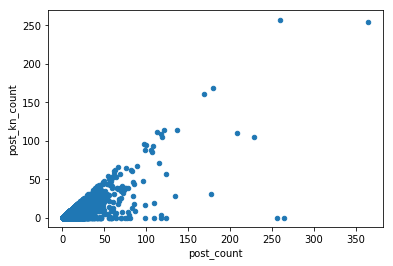

In [42]:
test.plot.scatter(x="post_count", y="post_kn_count")

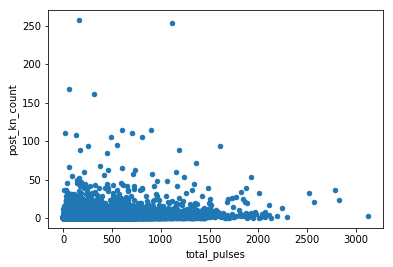

In [41]:
test.plot.scatter(x="total_pulses", y="post_kn_count")

In [ ]:
test[(test.total_pulses < 50) & (test.post_kn_count > 20)]

In [ ]:
all_event_df[all_event_df.user_id == 398209]

In [ ]:
test[(test.total_pulses < test.post_kn_count)]

In [41]:
86400*24

2073600

In [42]:
2093134 - 2073600

19534

In [43]:
19534/60

325.56666666666666

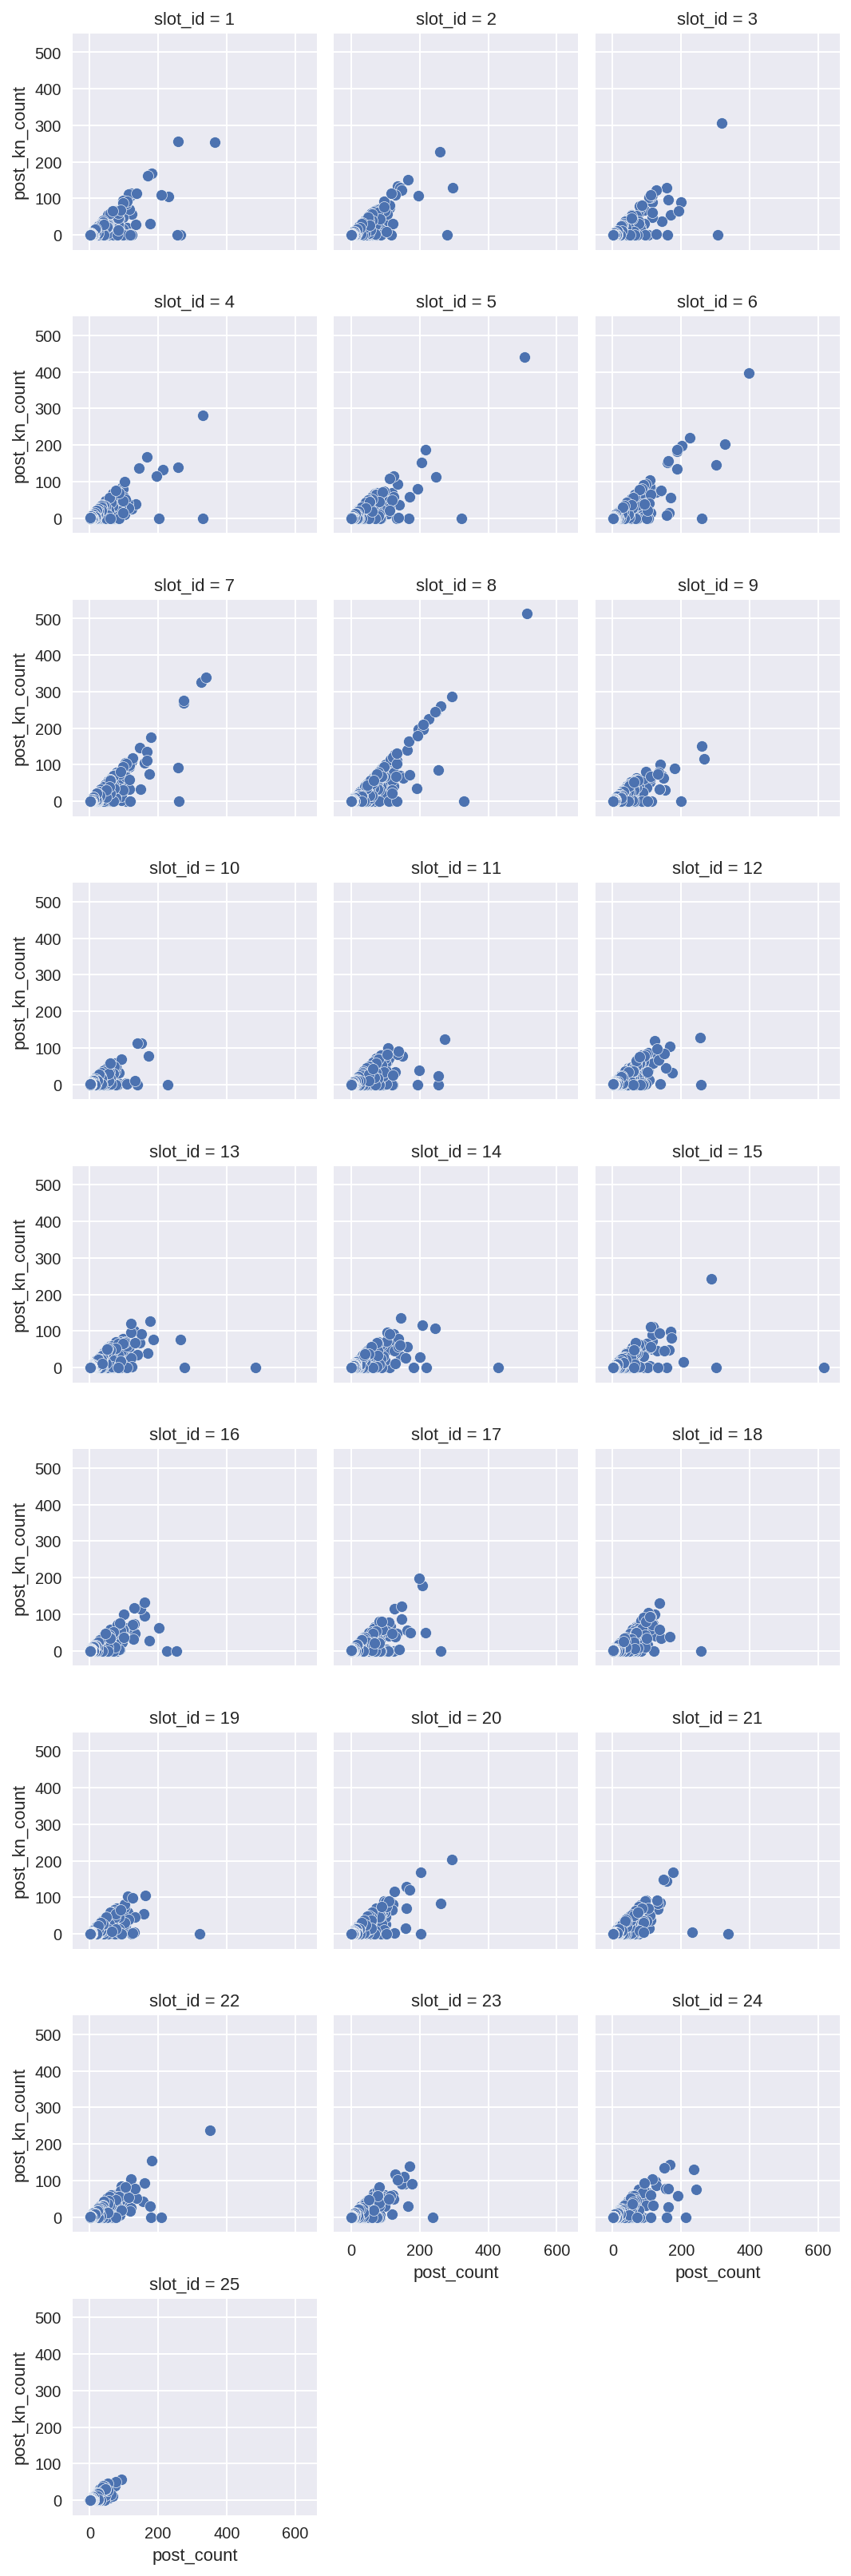

In [19]:
g = sns.FacetGrid(daily_stat, col="slot_id", col_wrap=3, size=2.5)
g.map(plt.scatter, "post_count", "post_kn_count", edgecolor="w")

CPU times: user 21.7 s, sys: 6.49 s, total: 28.2 s
Wall time: 21.4 s


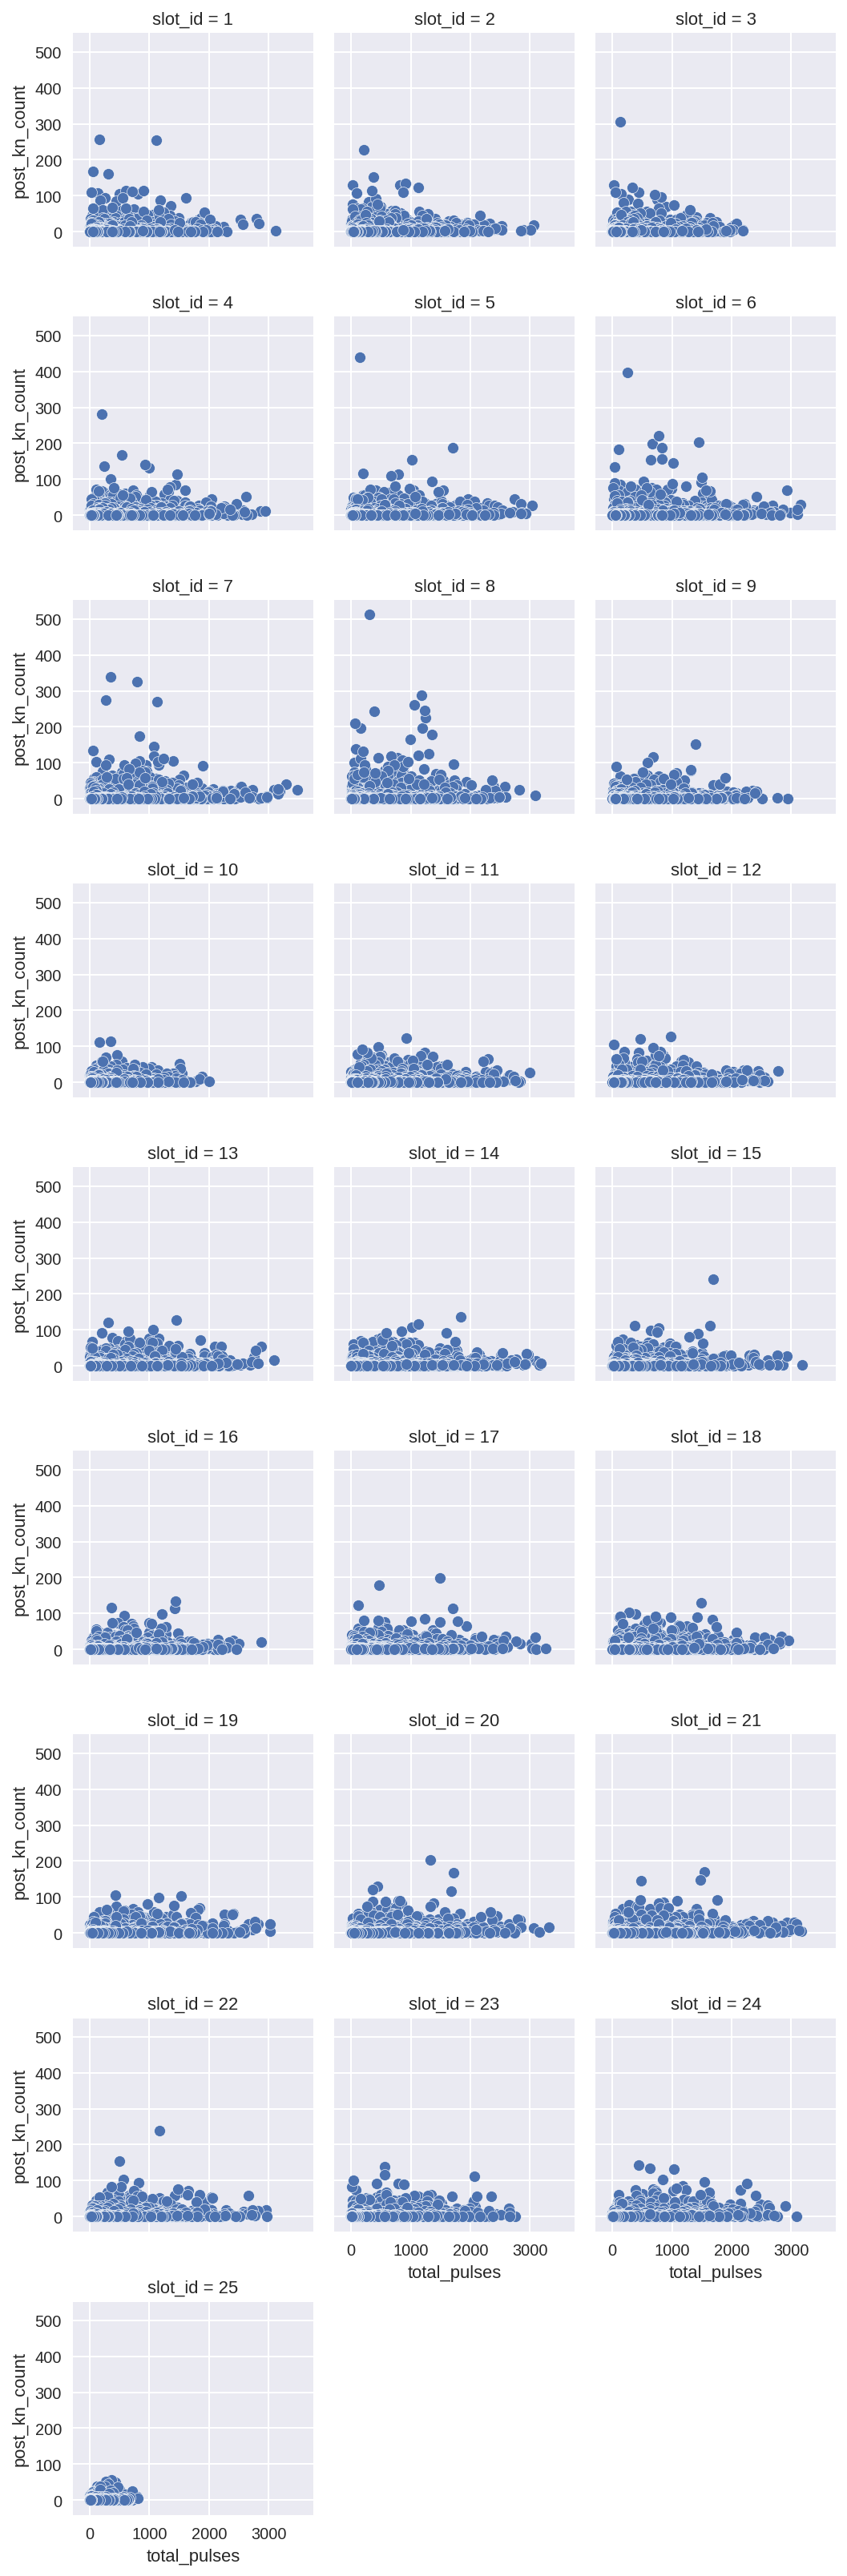

In [9]:
%%time
g = sns.FacetGrid(daily_stat, col="slot_id", col_wrap=3, size=2.5)
g.map(plt.scatter, "total_pulses", "post_kn_count", edgecolor="w")

In [ ]:
grp = daily_stat.groupby(by=['user_id','slot_id'])

for name, group in grp:
    print (name)
    print (group)

In [10]:
daily_stat.head()

slot_id  user_id  post_count  post_kn_count  total_pulses
0        1    95315          25              9           444
1        1   134826           2              0            85
2        1   112546           2              0           261
3        1   279120           1              0            14
4        1    74017           1              0             3

In [14]:
len(daily_stat)

3819208

In [15]:
len(daily_stat[daily_stat.post_kn_count > daily_stat.total_pulses])

891

In [16]:
len(daily_stat[daily_stat.post_count > daily_stat.total_pulses])

289031

In [17]:
289031/3819208

0.07567825580591578

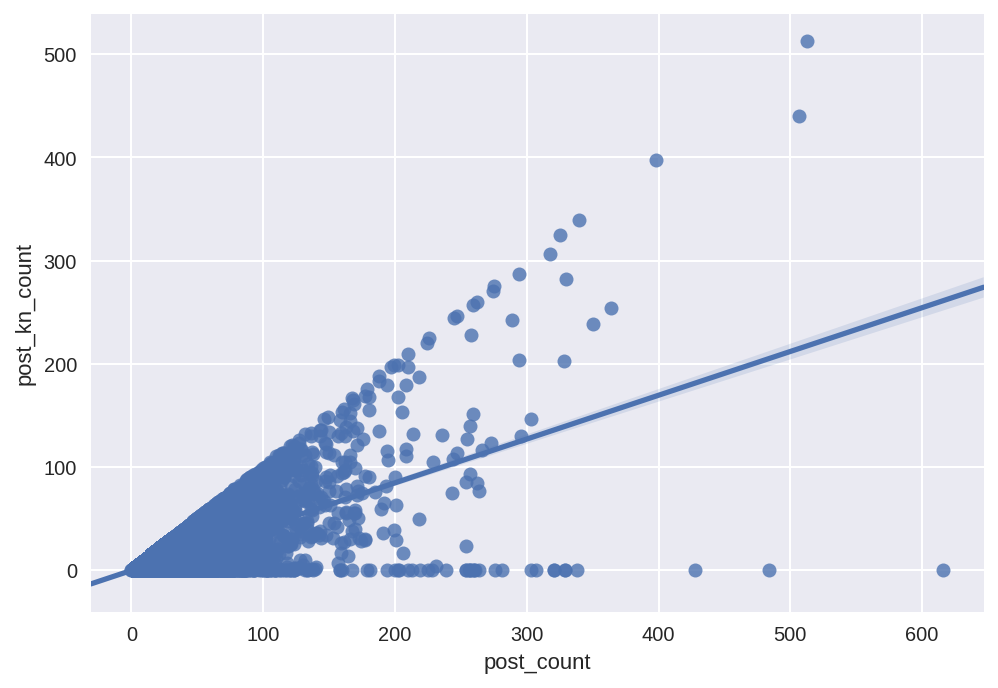

In [20]:
sns.regplot(x="post_count", y="post_kn_count", data=daily_stat)

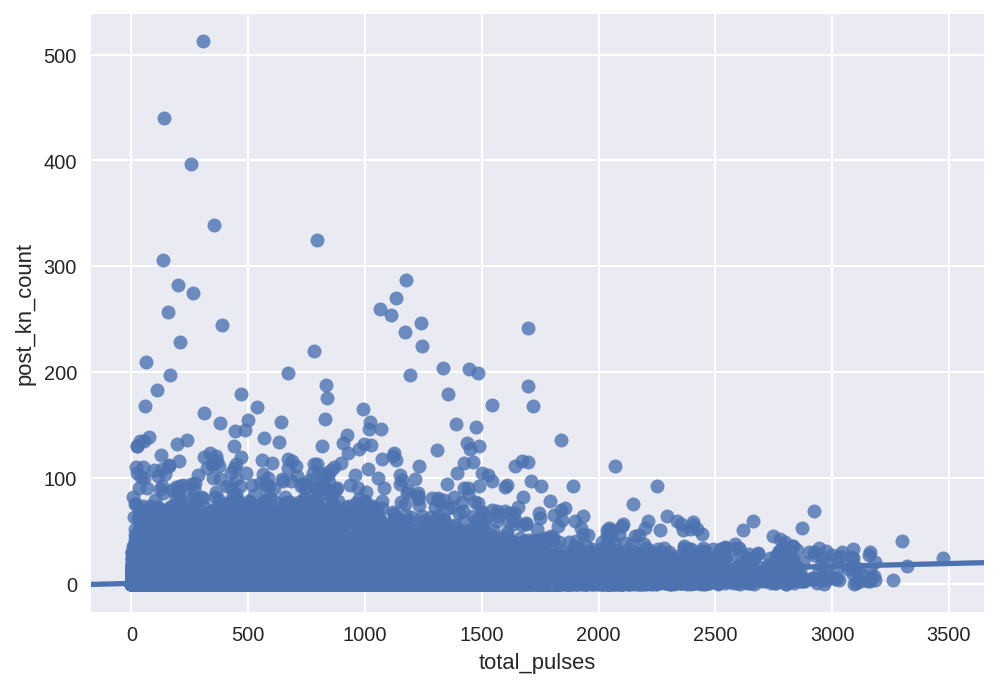

In [22]:
sns.regplot(x="total_pulses", y="post_kn_count", data=daily_stat)

In [21]:
daily_stat.mean()

slot_id              13.040147
user_id          267383.946118
post_count            2.367151
post_kn_count         0.550864
total_pulses         68.231299
dtype: float64

In [53]:
len(daily_stat[daily_stat.post_count > 1])

1802995

In [56]:
daily_stat[(daily_stat.post_count < 100)].mean()

slot_id              13.040293
user_id          267391.214765
post_count            2.347503
post_kn_count         0.541299
total_pulses         68.168376
dtype: float64

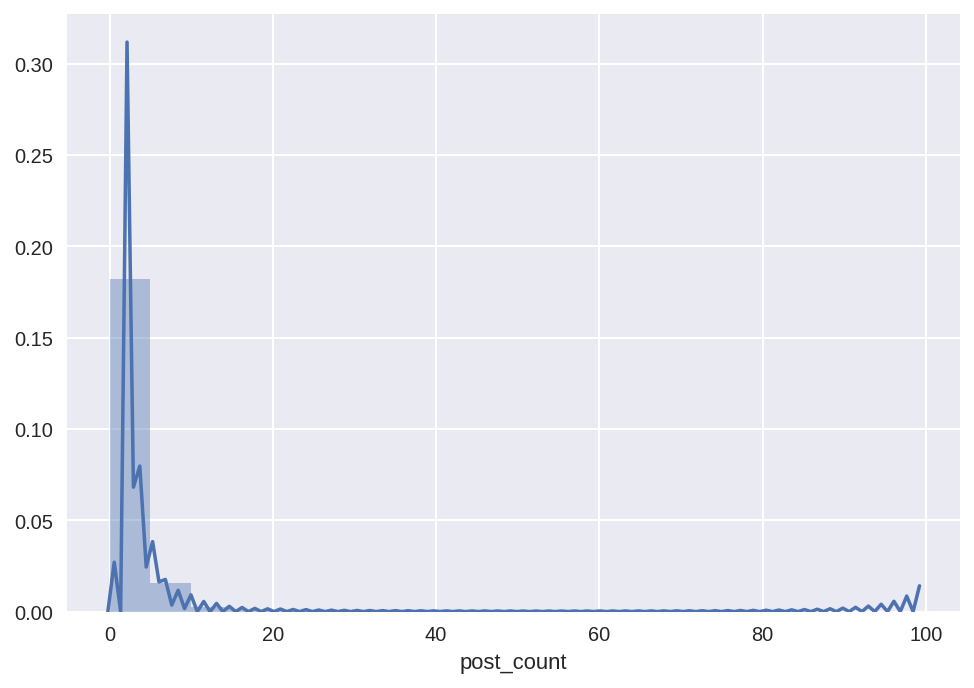

In [55]:
sns.distplot(daily_stat[(daily_stat.post_count < 100)].post_count, bins=20)

In [59]:
ratio = (daily_stat.post_kn_count / daily_stat.total_pulses)

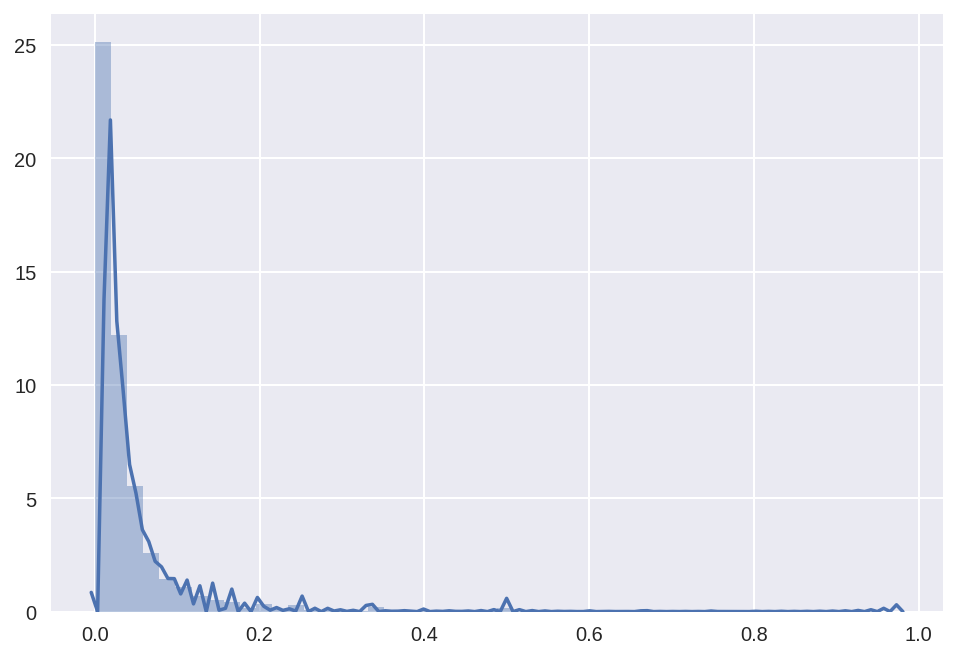

In [91]:
sns.distplot(ratio[(ratio < 1) & (ratio > 0)].fillna(0))

In [88]:
(ratio.fillna(0))[ratio < 1].mean()

0.011273422172572649

In [93]:
ratio.mean()

0.012359309877418057

In [95]:
daily_stat.groupby(by="slot_id").sum().post_kn_count.mean()

84154.64

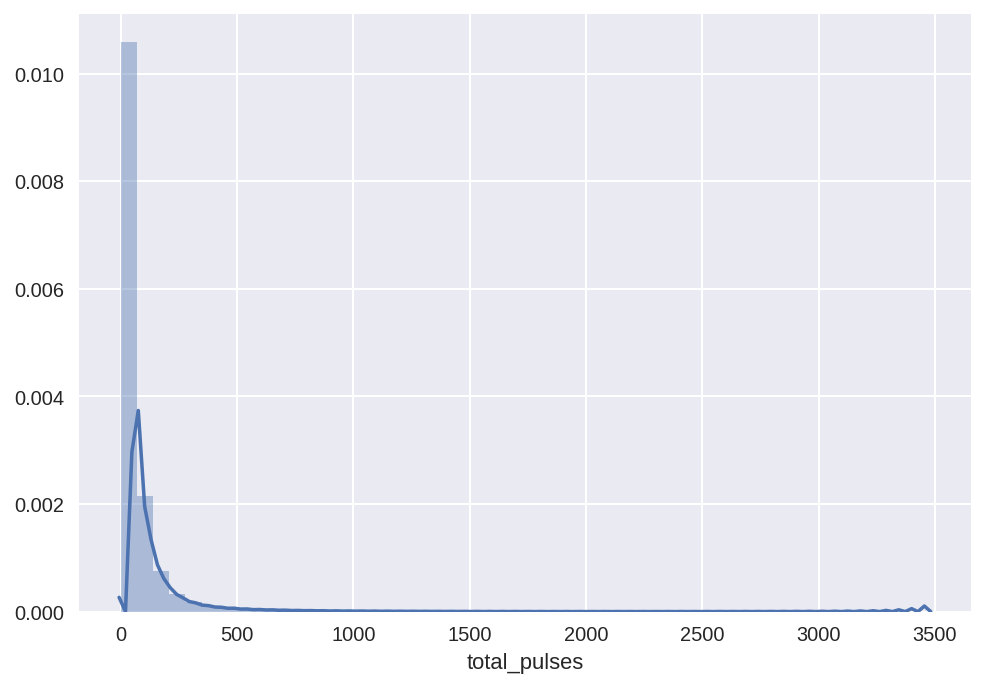

In [98]:
sns.distplot(daily_stat.total_pulses)

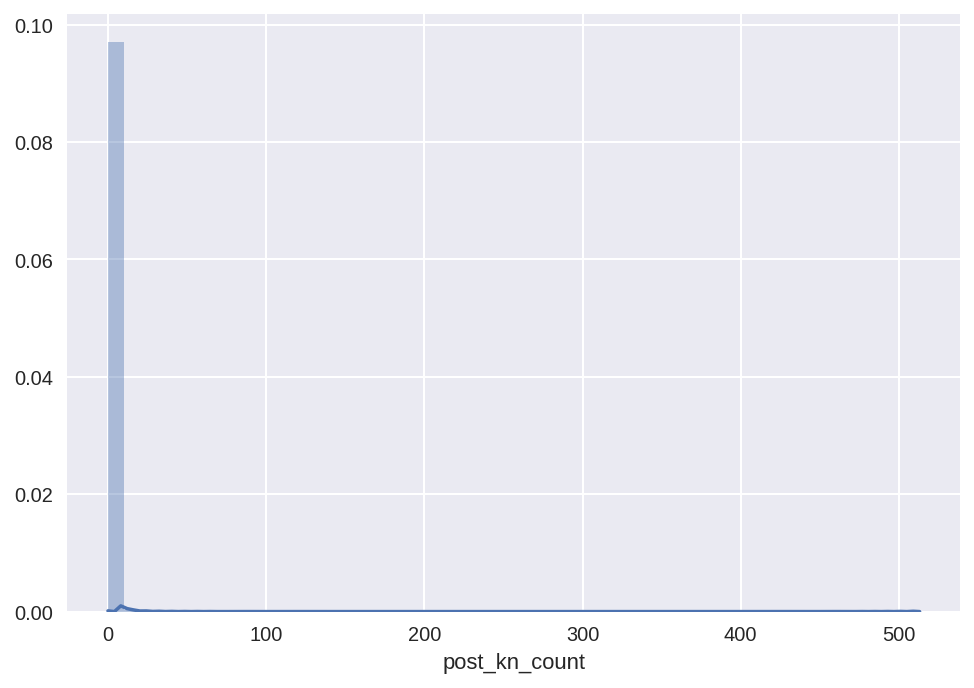

In [99]:
sns.distplot(daily_stat.post_kn_count)

In [115]:
daily_stat[daily_stat.total_pulses > 10].mean()

slot_id              13.033991
user_id          218798.292297
post_count            2.523499
post_kn_count         0.712124
total_pulses         89.734349
dtype: float64

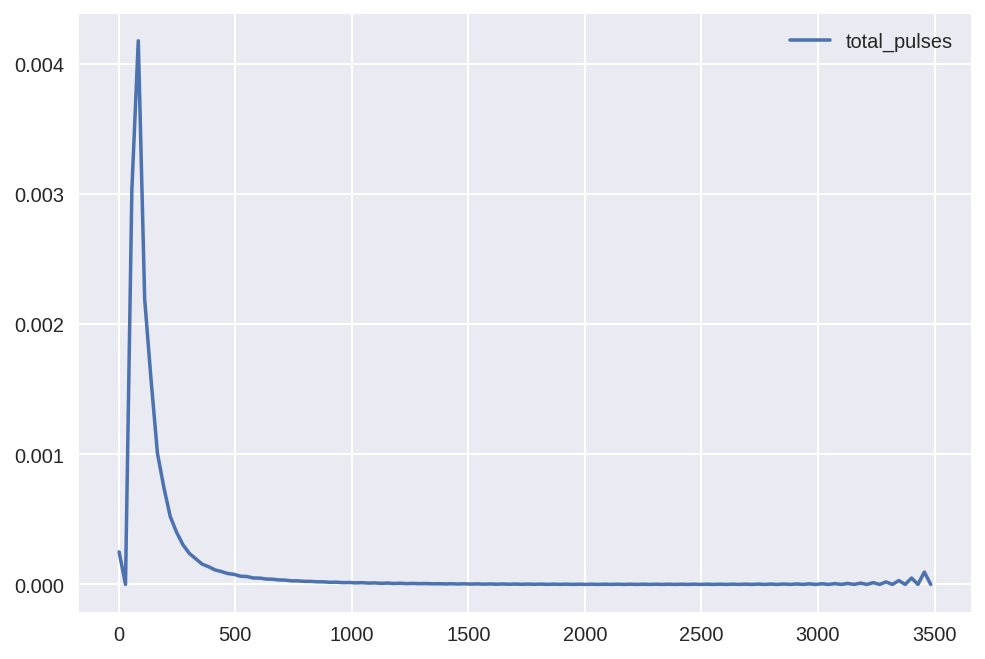

In [131]:
sns.kdeplot(daily_stat[daily_stat.total_pulses > 10].total_pulses)

In [ ]:
ratio.sort_values(ascending=False)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


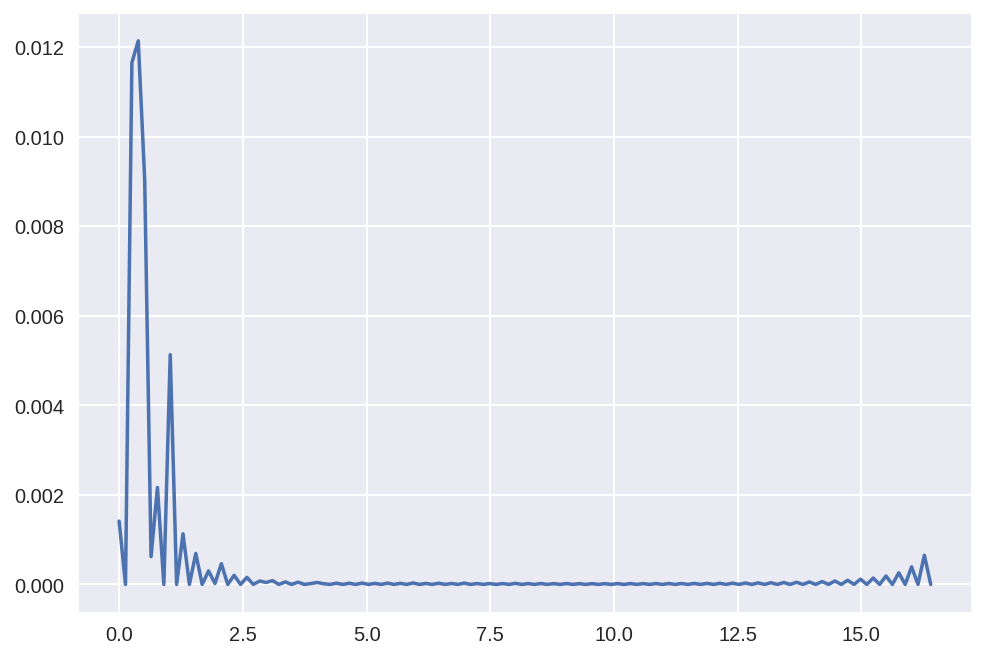

In [142]:
sns.kdeplot(ratio)

In [9]:
ds_without_extream = daily_stat[(daily_stat.total_pulses > 10)]

In [10]:
len(ds_without_extream)

2861657

In [156]:
ratio1 = (ds_without_extream.post_kn_count / ds_without_extream.total_pulses)

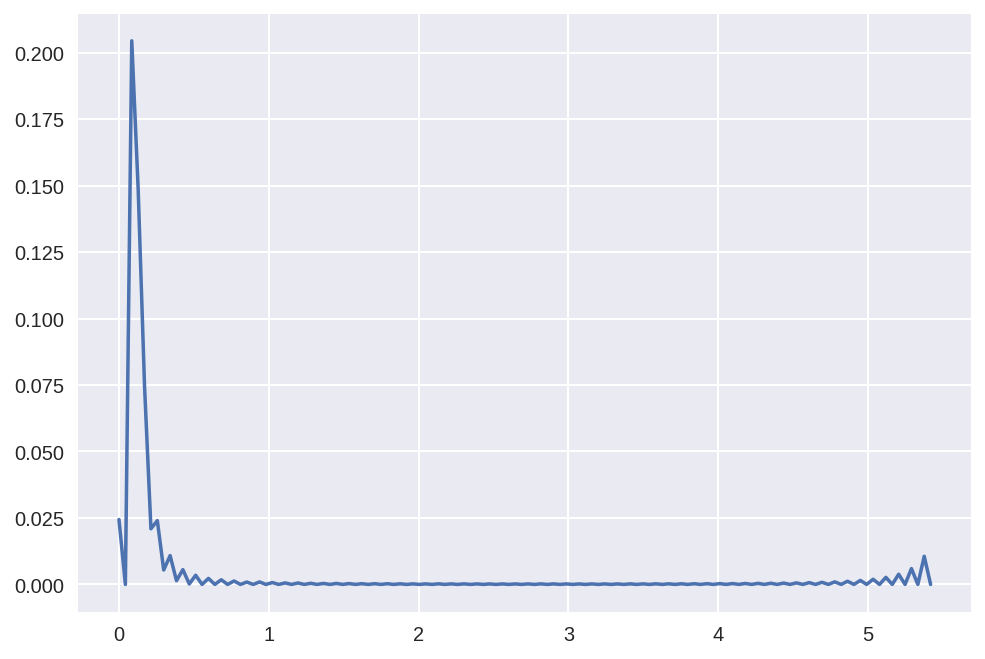

In [157]:
sns.kdeplot(ratio1)

In [158]:
ratio1.mean()

0.010793479283741617

In [161]:
len(ds_without_extream.user_id.unique())

382019

In [164]:
len(daily_stat.user_id.unique())

496644

In [ ]:
ratio1[ratio1 > 0.0].mean()

In [ ]:
gt_0 = ds_without_extream[(ds_without_extream.post_kn_count / ds_without_extream.total_pulses > 0)]
#gt_0 = ratio1[ratio1 > 0]
gt_0.head()

In [ ]:
len(gt_0.groupby(by='user_id'))

#### like to see how membership changes over time

In [187]:
r = ratio1[ratio1 <= 1]

In [ ]:
ratio1[ratio1 <= 1].sort_values(ascending=False)

In [189]:
rang = range(0, 10, 1)
for i in rang:
    low = i/10
    high = (i+1)/10
    print(len(r[(r > low) & (r <= high)]))

944350
29932
5150
1859
776
350
227
125
58
73


In [171]:
r[r>500]

19947     523.809524
148488    541.666667
324770    520.000000
779698    535.714286
dtype: float64

In [255]:
def large(x, midpoint, spread):
    print((x**spread))
    return 1/(1 + 1/((x**spread)*midpoint))

def ms_large(x, a, b, mean, sd):
    if(x > a*mean):
        return 1 - ((b*sd)/(x - a*mean + b*sd))
    else:
        return 0

ms_large(2.01, 0.2, 1, 0.031420408457794494, 0.04750672983668915)

0.9768397985076616

In [18]:
gp = stats_mem.groupby(by="user_id")
len(gp)

496644

### Calculating FRW membership

In [21]:
def gateway_post_count(row):
    return row["post_count"] - row["post_kn_count"]

In [22]:
%%time

ddf = dd.from_pandas(stats_mem, npartitions=number_of_process, sort=False)
xyz = ddf.apply(gateway_post_count, axis=1).compute(get=multiprocessing.get)
xyz.name = "gw_post_count"
stats_mem_BT = pd.concat([stats_mem, xyz], axis=1)

/home/suman/tools/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


CPU times: user 722 ms, sys: 1.34 s, total: 2.06 s
Wall time: 40.1 s


In [19]:
gp = stats_mem_BT.groupby("slot_id")

In [ ]:
user_gw_mem = pd.DataFrame(stats_mem_BT.groupby(by="user_id").mean()['gw_post_count'], columns=["gw_post_count"]);
user_gw_mem['user_id'] = user_gw_mem.index
user_gw_mem.index.name = 'Index'
user_gw_mem.head()

In [24]:
%%time

ddf = dd.from_pandas(daily_stat_test, npartitions=number_of_process, sort=False)
xyz = ddf.apply(gateway_post_count, axis=1).compute(get=multiprocessing.get)
xyz.name = "gw_post_count"
stats_mem_BT_testing = pd.concat([daily_stat_test, xyz], axis=1)

/home/suman/tools/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


CPU times: user 229 ms, sys: 377 ms, total: 606 ms
Wall time: 13.1 s


In [25]:
user_con_test = pd.DataFrame(stats_mem_BT_testing.groupby(by="user_id").mean()[['post_kn_count', 'total_pulses']]);
user_con_test.reset_index(inplace=True)
user_con_test.head()

user_id  post_kn_count  total_pulses
0        1       1.000000     75.500000
1        2       0.500000     77.500000
2        3       0.000000     84.500000
3        5       1.250000    678.250000
4        6       0.857143    282.857143

In [ ]:
user_gw_test = pd.DataFrame(stats_mem_BT_testing.groupby(by="user_id").mean()['gw_post_count'], columns=["gw_post_count"]);
user_gw_test['user_id'] = user_gw_test.index
user_gw_test.index.name = 'Index'
user_gw_test.head()

In [59]:
stats_mem_BT.gw_post_count.mean()
stats_mem_BT.gw_post_count.std()

1.8162865180424843

2.557479742014192

In [27]:
def calculate_gateway_mem(row):
    return ms_large(row['gw_post_count'], 1, 3, 1.81629, 2.55748)

In [28]:
%%time

ddf = dd.from_pandas(user_gw_mem, npartitions=number_of_process, sort=False)
xyz = ddf.apply(calculate_gateway_mem, axis=1).compute(get=multiprocessing.get)
xyz.name = "gateway_membership"
user_gw_mem = pd.concat([user_gw_mem, xyz], axis=1)

/home/suman/tools/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


CPU times: user 87.1 ms, sys: 179 ms, total: 266 ms
Wall time: 3.26 s


In [29]:
training_ranking = user_gw_mem.sort_values(by='gateway_membership', ascending=False)

In [30]:
testing_ranking = user_gw_test.sort_values(by='gw_post_count', ascending=False)

In [31]:
predicted_rank = training_ranking.reset_index()
predicted_rank['prank'] = predicted_rank.index
predicted_rank.head()

Index  gw_post_count  user_id  gateway_membership  prank
0  596925     251.120000   596925            0.970143      0
1  249550     144.777778   249550            0.949066      1
2  143413     113.480000   143413            0.935707      2
3  233648     108.680000   233648            0.933013      3
4  271938      89.333333   271938            0.919398      4

In [36]:
true_rank = testing_ranking.reset_index()
true_rank['trank'] = true_rank.index
true_rank.head()

Index  gw_post_count  user_id  trank
0  596925     202.000000   596925      0
1  143413     138.777778   143413      1
2  487348     133.000000   487348      2
3   48133      96.222222    48133      3
4  475421      89.000000   475421      4

In [33]:
user_con_mem.head()

user_id  consumer
0        0  0.051917
1        1  0.028318
2        2  0.036034
3        3  0.078008
4        4  0.000000

In [50]:
predicted_rank.head()

Index  gw_post_count  user_id  gateway_membership  prank
0  596925     251.120000   596925            0.970143      0
1  249550     144.777778   249550            0.949066      1
2  143413     113.480000   143413            0.935707      2
3  233648     108.680000   233648            0.933013      3
4  271938      89.333333   271938            0.919398      4

In [51]:
predicted_rank.rename(columns={'gateway_membership':'width', 'prank':'p_width_rank'}, inplace=True)

In [52]:
predicted_rank.head()

Index  gw_post_count  user_id     width  p_width_rank
0  596925     251.120000   596925  0.970143             0
1  249550     144.777778   249550  0.949066             1
2  143413     113.480000   143413  0.935707             2
3  233648     108.680000   233648  0.933013             3
4  271938      89.333333   271938  0.919398             4

In [53]:
len(predicted_rank)
x = predicted_rank.merge(user_con_mem, on='user_id', how='left')
len(x)

496644

496644

In [54]:
x.head()

Index  gw_post_count  user_id     width  p_width_rank  consumer
0  596925     251.120000   596925  0.970143             0  0.000000
1  249550     144.777778   249550  0.949066             1  0.083829
2  143413     113.480000   143413  0.935707             2  0.445943
3  233648     108.680000   233648  0.933013             3  0.539517
4  271938      89.333333   271938  0.919398             4  0.570153

In [55]:
x.rename(columns={'consumer':'depth'}, inplace=True)
x.sort_values(by="depth", ascending=False, inplace=True)
x.head()

Index  gw_post_count  user_id     width  p_width_rank     depth
440073  286353            1.0   286353  0.000000        440073  0.960248
93963   351885            2.0   351885  0.023384         93963  0.954374
82      453348           29.0   453348  0.779883            82  0.952472
195306  527686            1.0   527686  0.000000        195306  0.945679
25240   476690            3.0   476690  0.133660         25240  0.938666

In [56]:
x.reset_index(inplace=True)

In [58]:
x['p_depth_rank'] = x.index

In [60]:
x.drop(columns=['index', 'Index'], inplace=True)

In [63]:
predicted_ranking_all = x
del x

NameError: name 'x' is not defined

In [64]:
predicted_ranking_all.head()

gw_post_count  user_id     width  p_width_rank     depth  p_depth_rank
0            1.0   286353  0.000000        440073  0.960248             0
1            2.0   351885  0.023384         93963  0.954374             1
2           29.0   453348  0.779883            82  0.952472             2
3            1.0   527686  0.000000        195306  0.945679             3
4            3.0   476690  0.133660         25240  0.938666             4

In [65]:
true_rank.head()

Index  gw_post_count  user_id  trank
0  596925     202.000000   596925      0
1  143413     138.777778   143413      1
2  487348     133.000000   487348      2
3   48133      96.222222    48133      3
4  475421      89.000000   475421      4

In [66]:
len(true_rank)
x = true_rank.merge(user_con_test, on='user_id', how='left')
len(x)

404026

404026

In [67]:
x.head()

Index  gw_post_count  user_id  trank  post_kn_count  total_pulses
0  596925     202.000000   596925      0       0.000000      0.000000
1  143413     138.777778   143413      1      19.888889    412.888889
2  487348     133.000000   487348      2      18.222222     39.444444
3   48133      96.222222    48133      3      52.888889   1160.222222
4  475421      89.000000   475421      4       0.000000     10.000000

In [68]:
x.drop(columns=['Index'], inplace=True)
x.rename(columns={'trank':'t_width_rank'}, inplace=True)
x.head()

gw_post_count  user_id  t_width_rank  post_kn_count  total_pulses
0     202.000000   596925             0       0.000000      0.000000
1     138.777778   143413             1      19.888889    412.888889
2     133.000000   487348             2      18.222222     39.444444
3      96.222222    48133             3      52.888889   1160.222222
4      89.000000   475421             4       0.000000     10.000000

In [69]:
x['ratio'] = x.post_kn_count/x.total_pulses
x.head()

gw_post_count  user_id  t_width_rank  post_kn_count  total_pulses     ratio
0     202.000000   596925             0       0.000000      0.000000       NaN
1     138.777778   143413             1      19.888889    412.888889  0.048170
2     133.000000   487348             2      18.222222     39.444444  0.461972
3      96.222222    48133             3      52.888889   1160.222222  0.045585
4      89.000000   475421             4       0.000000     10.000000  0.000000

In [70]:
x.ratio.fillna(0, inplace=True)

In [71]:
x.sort_values(by='ratio', ascending=False, inplace=True)
x.reset_index(inplace=True)
x.head()

index  gw_post_count  user_id  t_width_rank  post_kn_count  total_pulses  \
0  291576            1.0   103049        291576            4.0           0.5   
1    8593            4.5   435167          8593            2.5           0.5   
2   44719            2.5   555259         44719            2.5           0.5   
3  294306            1.0    79961        294306           13.0           3.0   
4  373220            0.5    41613        373220            3.5           1.0   

      ratio  
0  8.000000  
1  5.000000  
2  5.000000  
3  4.333333  
4  3.500000

In [72]:
x.drop(columns='index', axis=1, inplace=True)

In [73]:
x['t_depth_rank'] = x.index

In [74]:
true_ranking_all = x
del x

In [75]:
predicted_ranking_all.head()
true_ranking_all.head()

gw_post_count  user_id     width  p_width_rank     depth  p_depth_rank
0            1.0   286353  0.000000        440073  0.960248             0
1            2.0   351885  0.023384         93963  0.954374             1
2           29.0   453348  0.779883            82  0.952472             2
3            1.0   527686  0.000000        195306  0.945679             3
4            3.0   476690  0.133660         25240  0.938666             4

gw_post_count  user_id  t_width_rank  post_kn_count  total_pulses  \
0            1.0   103049        291576            4.0           0.5   
1            4.5   435167          8593            2.5           0.5   
2            2.5   555259         44719            2.5           0.5   
3            1.0    79961        294306           13.0           3.0   
4            0.5    41613        373220            3.5           1.0   

      ratio  t_depth_rank  
0  8.000000             0  
1  5.000000             1  
2  5.000000             2  
3  4.333333             3  
4  3.500000             4

In [ ]:
joint_table = true_rank.merge(predicted_rank, on='user_id', how='inner')

In [76]:
joint_table_1 = true_ranking_all.merge(predicted_ranking_all, on='user_id', how='inner')

In [77]:
joint_table_1.head()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
0              1.0   103049        291576            4.0           0.5   
1              4.5   435167          8593            2.5           0.5   
2              1.0    79961        294306           13.0           3.0   
3              0.5    41613        373220            3.5           1.0   
4              1.0   566393        209445            3.5           1.0   

      ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  depth  \
0  8.000000             0         2.857143  0.119456         29430    0.0   
1  5.000000             1         2.285714  0.057656         56453    0.0   
2  4.333333             3         1.000000  0.000000        297556    0.0   
3  3.500000             4         1.571429  0.000000        378908    0.0   
4  3.500000             5         1.000000  0.000000        215028    0.0   

   p_depth_rank  
0        382800  
1        372259  
2        430764  
3        297583  
4        494205

In [20]:
avg_post_per_user = gp.gw_post_count.mean()

In [21]:
avg_post_per_user_per_day = avg_post_per_user.mean()

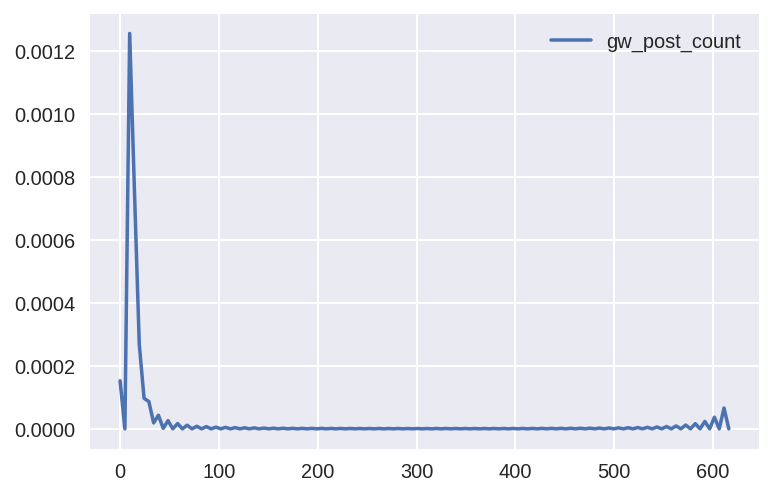

In [38]:
sns.kdeplot(stats_mem_BT.gw_post_count)

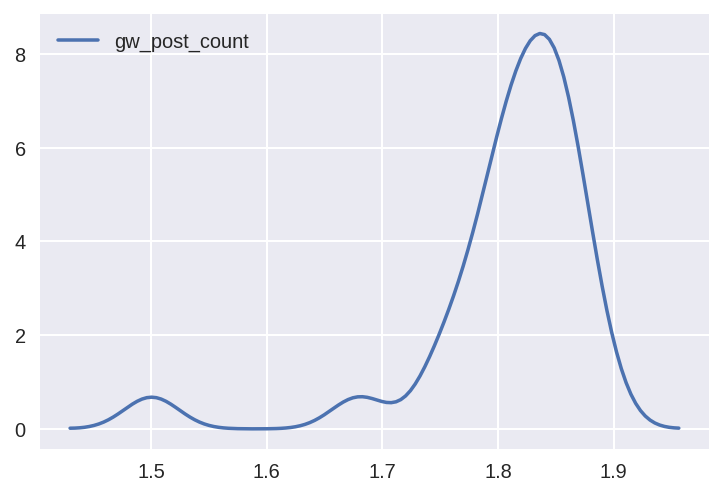

In [56]:
sns.kdeplot(avg_post_per_user)

In [78]:
joint_table_1.head()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
0              1.0   103049        291576            4.0           0.5   
1              4.5   435167          8593            2.5           0.5   
2              1.0    79961        294306           13.0           3.0   
3              0.5    41613        373220            3.5           1.0   
4              1.0   566393        209445            3.5           1.0   

      ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  depth  \
0  8.000000             0         2.857143  0.119456         29430    0.0   
1  5.000000             1         2.285714  0.057656         56453    0.0   
2  4.333333             3         1.000000  0.000000        297556    0.0   
3  3.500000             4         1.571429  0.000000        378908    0.0   
4  3.500000             5         1.000000  0.000000        215028    0.0   

   p_depth_rank  
0        382800  
1        372259  
2        430764  
3        297583  
4        494205

In [6]:
#joint_table_1.to_csv('datasets/twitter_2013/joint_table_1.csv')
joint_table_1 =pd.read_csv('datasets/twitter_2013/joint_table_1.csv', index_col=0)

In [7]:
joint_table_1.head()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
0              1.0   103049        291576            4.0           0.5   
1              4.5   435167          8593            2.5           0.5   
2              1.0    79961        294306           13.0           3.0   
3              0.5    41613        373220            3.5           1.0   
4              1.0   566393        209445            3.5           1.0   

      ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  depth  \
0  8.000000             0         2.857143  0.119456         29430    0.0   
1  5.000000             1         2.285714  0.057656         56453    0.0   
2  4.333333             3         1.000000  0.000000        297556    0.0   
3  3.500000             4         1.571429  0.000000        378908    0.0   
4  3.500000             5         1.000000  0.000000        215028    0.0   

   p_depth_rank  
0        382800  
1        372259  
2        430764  
3        297583  
4        494205

In [7]:
%%time

### AUC
count = 0
for i in range(10000):
    sample = joint_table_1.sample(2)
    
    r1 = sample.iloc[[0]]
    r2 = sample.iloc[[1]]
        
    if(r1.iloc[0].p_width_rank > r2.iloc[0].p_width_rank):
        if(r1.iloc[0].t_width_rank > r2.iloc[0].t_width_rank):
            count += 1
    elif(r1.iloc[0].p_width_rank < r2.iloc[0].p_width_rank):
        if(r1.iloc[0].t_width_rank < r2.iloc[0].t_width_rank):
            count += 1

print(count)

6204
Wall time: 2min 16s


In [ ]:
training_set_all_membership = predicted_rank.merge(memberships, on='user_id', how='inner')
training_set_all_membership.head()
len(predicted_rank)
len(training_set_all_membership)

In [8]:
joint_table_1.tail()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
389870         1.333333   355748        178492            0.0     23.666667   
389871         1.333333   153902        178490            0.0     35.666667   
389872         1.333333   195659        178487            0.0     13.833333   
389873         1.333333   607296        178486            0.0      0.000000   
389874         1.166667   182372        202013            0.0     29.500000   

        ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  \
389870    0.0        404021         1.642857  0.000000        168536   
389871    0.0        404022         1.411765  0.000000        460370   
389872    0.0        404023         1.500000  0.000000        489672   
389873    0.0        404024         1.000000  0.000000        212429   
389874    0.0        404025         2.500000  0.081821         44969   

           depth  p_depth_rank  
389870  0.052187        175516  
389871  0.083405        124758  
389872  0.050477        178622  
389873  0.000000        485633  
389874  0.080338        129064

In [24]:
daily_stat.head()

slot_id  user_id  post_count  post_kn_count  total_pulses
0        1    95315          25              9           444
1        1   134826           2              0            85
2        1   112546           2              0           261
3        1   279120           1              0            14
4        1    74017           1              0             3

In [26]:
daily_stat_test.head()

slot_id  user_id  post_count  post_kn_count  total_pulses
0        1   406958           5              0            48
1        1    22524           5              1            70
2        1   506934           3              0             9
3        1   598801           9              0             0
4        1    63480           1              0             3

In [28]:
pcount = daily_stat.groupby(by='user_id').post_count.sum()

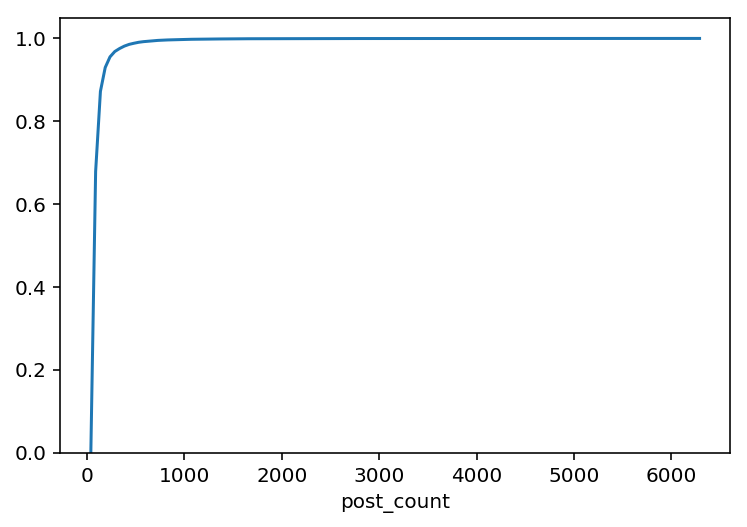

In [55]:
sns.distplot(pcount[pcount>50], hist=False, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

In [42]:
daily_stat['unq_p_count'] = daily_stat.post_count - daily_stat.post_kn_count

In [43]:
upcount = daily_stat.groupby(by='user_id').unq_p_count.sum()

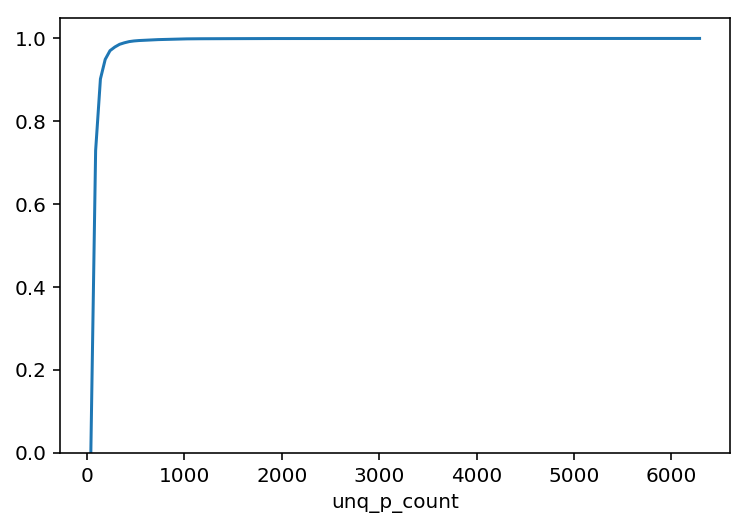

In [57]:
sns.distplot(upcount[upcount>50], hist=False, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

In [80]:
def InFlowMine(cascade, f, r, net):
    freq_tab = cascade.groupby(by='user_id').count()
    freq_tab.reset_index(inplace=True)
    fi1 = freq_tab[freq_tab.tag > f]

    fk = {}
    old = set()
    pros = set()
    for n in fi1.user_id.values:
        fk.setdefault(n, set()).add(int(n))
        pros.add(int(n))

    loop = pros.difference(old)
    while(len(loop) > 0):
        pros = set()
        for n in loop:
            old.add(int(n))
            nei = [x for x in net.neighbors(n)]
            tmp = cascade[cascade['user_id'].isin(nei) & (cascade.parent_user_id == n)]
            tmp = tmp.groupby(by='user_id').count()
            f = tmp[tmp.parent_user_id > r].copy()
            if(len(f)>0):        
                for x in f.index.values:
                    fk.setdefault(n, set()).add(int(x))
                    fk.setdefault(x, set()).add(int(x))            
                    pros.add(int(x))
        loop = pros.difference(old)
    return fk


def NDIF(fk, k):
    V = []
    Vs = set()
    total = set()
    while len(V) < k:
        if(len(V)%100 == 0):
            print(len(V))
        l = 0
        j = 0
        for x in fk:
            if x in Vs:
                continue
            tl = len(total.union(fk[x]))
            if(tl > l):
                l = tl
                j = x

        if(j != 0):
            V.append(j)
            Vs.add(j)
            total = total.union(fk[j])
        else:
            break
    
    return pd.DataFrame(V, columns=['node'])

In [132]:
%%time
fkl = InFlowMine(train_src, 25, 10, network)
#topk = NDIF(fkl, )

CPU times: user 3h 13min 19s, sys: 2min 37s, total: 3h 15min 56s
Wall time: 3h 15min 55s


In [78]:
#save_obj(fkl, "in_flow_25_10")
fkl = load_obj("in_flow_25_10")

In [81]:
%%time
topk = NDIF(fkl, 500)

0
100
200
300
400
CPU times: user 9min 26s, sys: 110 ms, total: 9min 26s
Wall time: 9min 26s


In [100]:
proposed500 = joint_table_1.sort_values(by='p_width_rank').head(500)

In [28]:
joint_table_1.head()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
0              1.0   103049        291576            4.0           0.5   
1              4.5   435167          8593            2.5           0.5   
2              1.0    79961        294306           13.0           3.0   
3              0.5    41613        373220            3.5           1.0   
4              1.0   566393        209445            3.5           1.0   

      ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  depth  \
0  8.000000             0         2.857143  0.119456         29430    0.0   
1  5.000000             1         2.285714  0.057656         56453    0.0   
2  4.333333             3         1.000000  0.000000        297556    0.0   
3  3.500000             4         1.571429  0.000000        378908    0.0   
4  3.500000             5         1.000000  0.000000        215028    0.0   

   p_depth_rank  
0        382800  
1        372259  
2        430764  
3        297583  
4        494205

In [32]:
ndif = topk.head(20)
pot = proposed500.head(20)
    
print(joint_table_1.merge(ndif, left_on='user_id', right_on='node', how='inner').gw_post_count_x.sum())
print(joint_table_1.merge(pot, left_on='user_id', right_on='user_id', how='inner').gw_post_count_x_x.sum())

211.65277777777777
1205.2972222222224


In [73]:
%%time
deg = sorted(network.degree(), key=lambda ele: ele[1], reverse=True)
degx = pd.DataFrame([[int(x[0]), int(x[1])] for x in deg], columns=['node', 'degree'])

CPU times: user 4.18 s, sys: 44 ms, total: 4.22 s
Wall time: 4.22 s


In [74]:
%%time
dd_base = degx.copy()

edg_list = nx.to_pandas_edgelist(network)
edg_list['target'] = edg_list['target'].apply(pd.to_numeric)
edg_list = edg_list.merge(dd_base, left_on='target', right_on='node')
ndeg = edg_list.groupby(by='source').degree.sum()
ndeg = ndeg.reset_index()
ndeg['source'] = ndeg['source'].apply(pd.to_numeric)
dd_base = dd_base.merge(ndeg, left_on='node', right_on='source')

CPU times: user 2min 26s, sys: 3.06 s, total: 2min 29s
Wall time: 2min 28s


In [75]:
def degree_discount(d, k, p):
    degdis = d.copy()
    degdis['dd'] = degdis.degree
    degdis['tv'] = 0

    data = set()
    for i in range(k):
        node = degdis.sort_values(by='dd', ascending=False).node.values[i]
        nei = network.neighbors(node)
    
        for n in nei:
            n = int(n)
            if (n in data):
                #print(n)
                continue
            n_row = degdis.index[degdis.node == n]
        
            r = degdis[degdis.node == n]
            tv = r.tv.values[0] + 1
            degdis.at[n_row, 'tv'] = tv
            degdis.at[n_row, 'dd'] = r.degree.values[0] - 2*tv - (r.degree.values[0] - tv)*tv*p
        data.add(node)
    
    return degdis.sort_values(by='dd', ascending=False).head(k)

In [76]:
%%time 

'''Degree Discount'''
ddis_topk = degree_discount(degx, 500, 0.2)

'Degree Discount'

In [77]:
%%time
'''Diffusion degree'''
dd_base['dd_score'] = dd_base.degree_x * 0.2 + dd_base.degree_y * 0.2
dd_topk = dd_base.sort_values(by='dd_score', ascending=False).head(500)

CPU times: user 106 ms, sys: 7 ms, total: 113 ms
Wall time: 111 ms


## Section 46, 2018

In [105]:
#topk.to_csv('datasets/twitter_2013/sec_46_2018/ndif500.csv')
#proposed500.to_csv('datasets/twitter_2013/sec_46_2018/width500.csv')
#degx.to_csv('datasets/twitter_2013/sec_46_2018/degree500.csv')
#ddis_topk.to_csv('datasets/twitter_2013/sec_46_2018/ddis500.csv')
#dd_topk.to_csv('datasets/twitter_2013/sec_46_2018/dd500.csv')

In [215]:
joint_table_1.head()

gw_post_count_x  user_id  t_width_rank  post_kn_count  total_pulses  \
0              1.0   103049        291576            4.0           0.5   
1              4.5   435167          8593            2.5           0.5   
2              1.0    79961        294306           13.0           3.0   
3              0.5    41613        373220            3.5           1.0   
4              1.0   566393        209445            3.5           1.0   

      ratio  t_depth_rank  gw_post_count_y     width  p_width_rank  depth  \
0  8.000000             0         2.857143  0.119456         29430    0.0   
1  5.000000             1         2.285714  0.057656         56453    0.0   
2  4.333333             3         1.000000  0.000000        297556    0.0   
3  3.500000             4         1.571429  0.000000        378908    0.0   
4  3.500000             5         1.000000  0.000000        215028    0.0   

   p_depth_rank  
0        382800  
1        372259  
2        430764  
3        297583  
4        494205

In [152]:
%%time
data = []
for i in range(0, 501, 20):
    ndif = topk.head(i)
    pot = proposed500.head(i)
    d = degx.head(i)
    ddis = ddis_topk.head(i)
    dd = dd_topk.head(i)
    avg = z1.head(i)
    
    ndif_t = joint_table_1.merge(ndif, left_on='user_id', right_on='node', how='inner').gw_post_count_x.sum()
    d_t = joint_table_1.merge(d, left_on='user_id', right_on='node', how='inner').gw_post_count_x.sum()
    ddis_t = joint_table_1.merge(ddis, left_on='user_id', right_on='node', how='inner').gw_post_count_x.sum()
    dd_t = joint_table_1.merge(dd, left_on='user_id', right_on='node', how='inner').gw_post_count_x.sum()
    pot_t = pot.gw_post_count_x.sum()
    
    data.append([i, pot_t, 'Proposed'])
    data.append([i, ndif_t, 'NDIF'])    
    data.append([i, d_t, 'Degree'])
    data.append([i, ddis_t, 'Degree Discount'])
    data.append([i, dd_t, 'Difusion Degree'])

CPU times: user 12.7 s, sys: 37 ms, total: 12.8 s
Wall time: 12.7 s


In [153]:
plot_data = pd.DataFrame(data, columns=['seed', 'value', 'Algorithm'])

[Text(0, 0.5, 'total #externally influenced posts in test set'),
 Text(0.5, 0, 'top-$k$ nodes')]

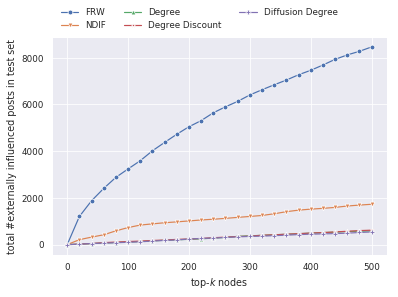

In [319]:
fig, ax = plt.subplots()

sns.set_context("paper")
sns.lineplot(data=plot_data, x='seed', y='value', dashes=False, hue='Algorithm', style='Algorithm', markers=['o', 'v', '^', '*', 'P'], legend=False)
ax.set(xlabel='top-$k$ nodes', ylabel='total #externally influenced posts in test set')
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['FRW','NDIF','Degree', 'Degree Discount', 'Diffusion Degree'])

fig.savefig("graphics/twitter_compare.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

In [152]:
len([x for x in fkl if len(fkl[x])>1])

152

In [4]:
len(fkl)

55220

[Text(0, 0.5, 'Membership'), Text(0.5, 0, '$x(u)$')]

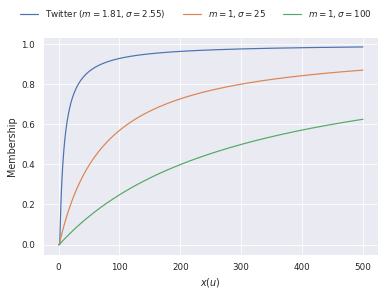

In [315]:
fig, ax = plt.subplots()

sns.set_context("paper")
x = []
y = []
for i in np.linspace(0, 500, 5000):
    x.append(i)
    y.append(ms_large(i, 1, 3, 1.81629, 2.55748))

sns.lineplot(x, y)

x = []
y = []
for i in np.linspace(0, 500, 5000):
    x.append(i)
    y.append(ms_large(i, 1, 3, 1, 25))
    
sns.lineplot(x, y)

x = []
y = []
for i in np.linspace(0, 500, 5000):
    x.append(i)
    y.append(ms_large(i, 1, 3, 1, 100))
    
sns.lineplot(x, y)

ax.set(xlabel='$x(u)$', ylabel='Membership')
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Twitter ($m=1.81, \sigma=2.55$)', '$m=1, \sigma=25$','$m=1, \sigma=100$'])

fig.savefig("graphics/mslarge.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')
